In [1]:
# type: ignore
import numpy as np

from nanopyx.core.transform.binning import rebin_2d
from nanopyx.core.transform.image_shift import *
from nanopyx.data.download import ExampleDataManager
from nanopyx.core.generate.noise_add_random_noise import get_perlin_noise

# downloader = ExampleDataManager()
# z = downloader.get_ZipTiffIterator('LongContinuous_UtrGFP')
# z = downloader.get_ZipTiffIterator('SMLMS2013_HDTubulinAlexa647')

# image = z[0]
M = 8
shiftM_x = 10
shiftM_y = 45
shift_x = shiftM_x / M
shift_y = shiftM_y / M
imageM = get_perlin_noise(32*M, 64*M, amp=1000, f=10, octaves=3)
imageM_shifted = np.zeros_like(imageM)
imageM_shifted[shiftM_y:, shiftM_x:] = imageM[:-shiftM_y, :-shiftM_x]
image = rebin_2d(imageM, M, mode="mean")
image_shifted_gt = rebin_2d(imageM_shifted, M, mode="mean")


In [2]:
%%prun -s cumulative -q -l 100 -T prun_shift.profile
# Profile the run

imageNNShift = nearest_neighbor_shift(image, shift_x, shift_y)
imageBLShift = bilinear_shift(image, shift_x, shift_y)
imageBCShift = bicubic_shift(image, shift_x, shift_y)
imageCRShift = catmull_rom_shift(image, shift_x, shift_y)
imageLShift = lanczos_shift(image, shift_x, shift_y)
imageScipyShift = scipy_shift(image, shift_x, shift_y)
imageSkiShift = skimage_shift(image, shift_x, shift_y)
imageCVShift = cv2_shift(image, shift_x, shift_y)


shifted_images = {
    "nearest-neighbor-shift": imageNNShift,
    "bilinear-shift": imageBLShift,
    "bilinear-shift": imageBLShift,
    "bicubic-shift": imageBCShift,
    "catmull-rom-shift": imageCRShift,
    "lanczos-shift": imageLShift,
    "scipy-shift": imageScipyShift,
    "skimage-shift": imageSkiShift,
    "cv2-shift": imageCVShift
}

nearest_neighbor_shift took 0.867844 mseconds
bilinear_shift took 0.692129 mseconds
bicubic_shift took 0.414371 mseconds
catmull_rom_shift took 0.311136 mseconds
lanczos_shift took 1.982212 mseconds
scipy_shift took 0.530958 mseconds
skimage_shift took 0.420094 mseconds
cv2_shift took 0.175238 mseconds
 
*** Profile printout saved to text file 'prun_shift.profile'.


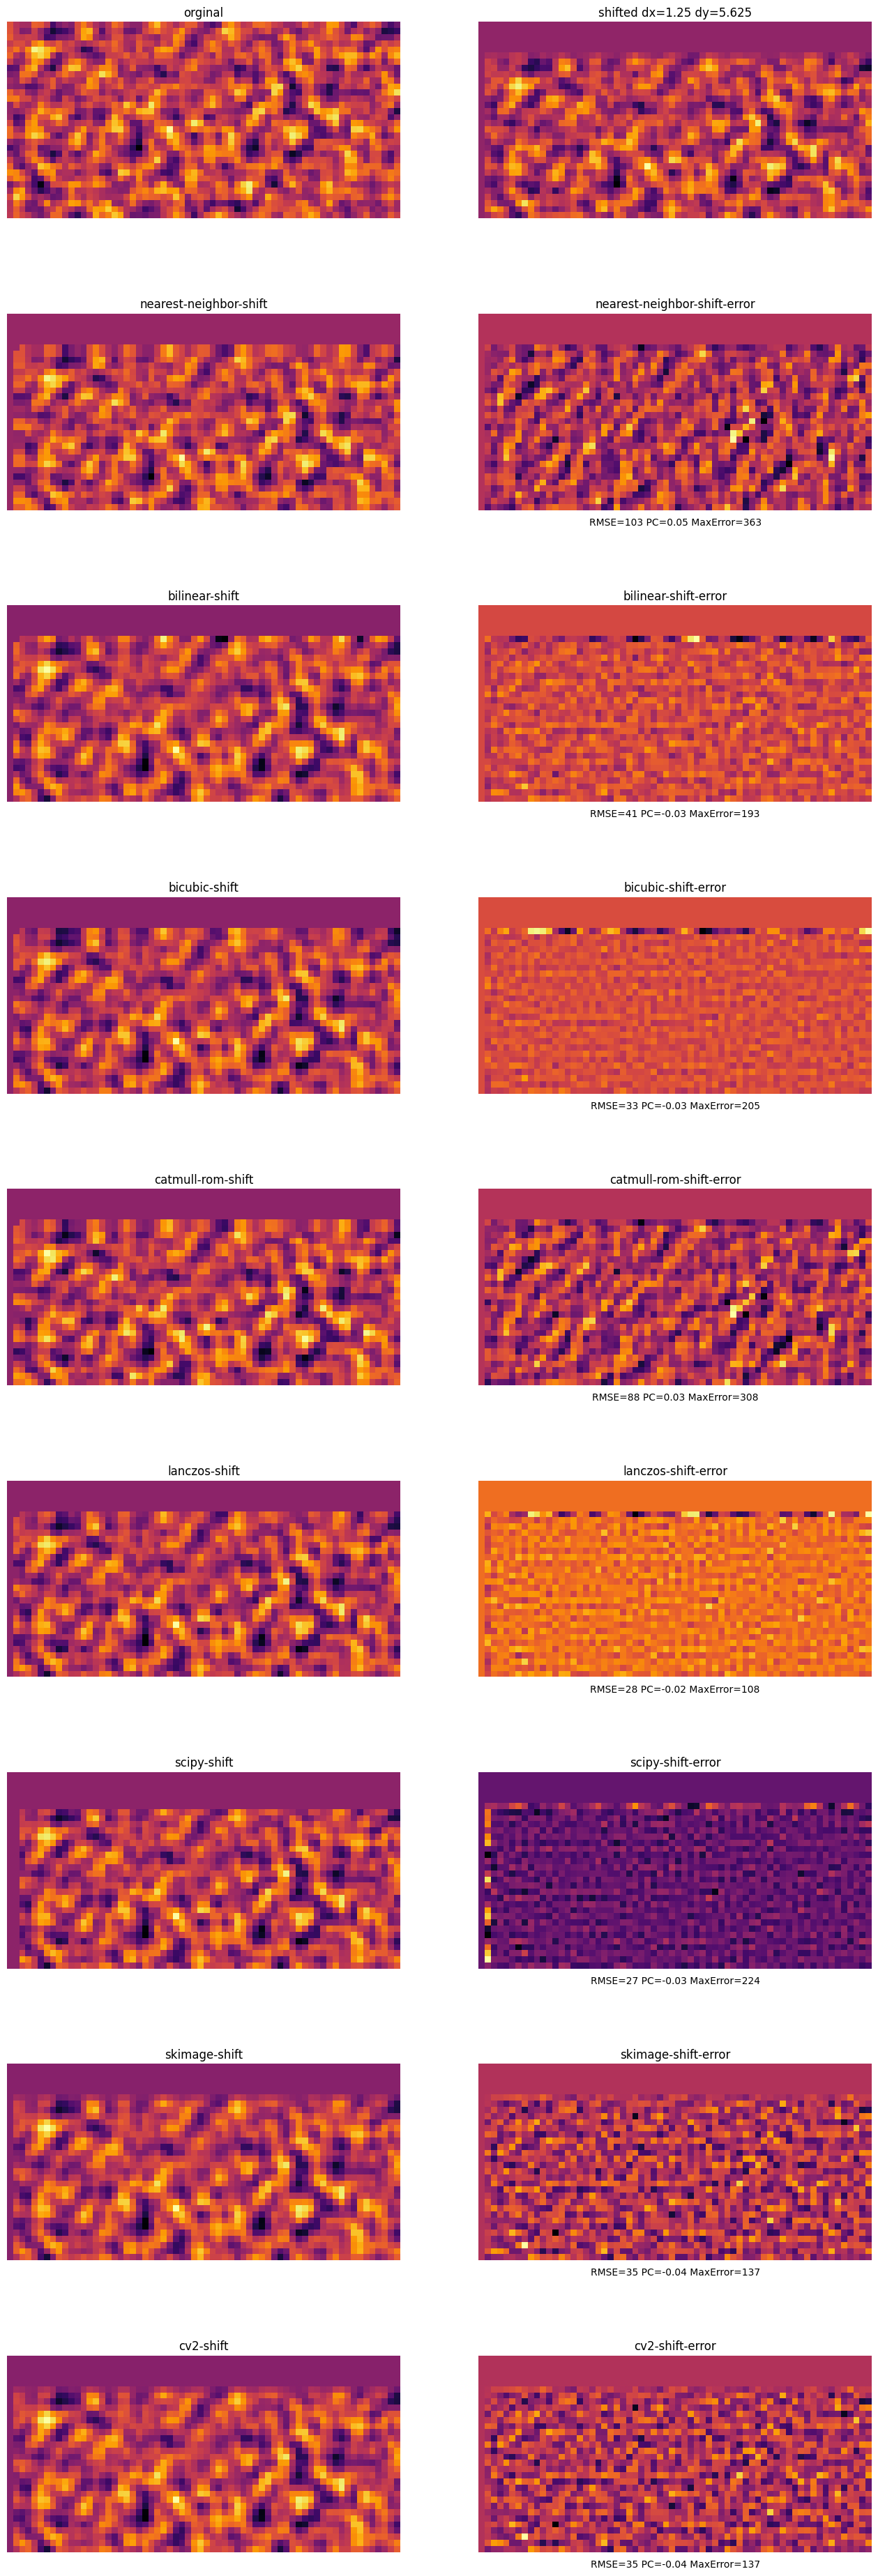

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from nanopyx.core.analysis.pearson_correlation import pearson_correlation
import numpy as np

# Create a figure with 3 subplots arranged in a row
fig, axs = plt.subplots(len(shifted_images)+1, 2, figsize=(16, 3*16))
sns.heatmap(image, ax=axs[0,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(image_shifted_gt, ax=axs[0,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[0,0].set_title("orginal")
axs[0,1].set_title(f"shifted dx={shift_x} dy={shift_y}")

for i, id in enumerate(shifted_images):
    shifted_image = shifted_images[id]
    error = image_shifted_gt-shifted_image
    rmse = round((error**2).mean()**0.5)
    pc = pearson_correlation(image, shifted_image)
    sns.heatmap(shifted_image, ax=axs[i+1,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
    sns.heatmap(error, ax=axs[i+1,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
    axs[i+1,0].set_title(f"{id}")
    axs[i+1,1].set_title(f"{id}-error")
    axs[i+1,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

# Show the figure
plt.show()
